In [1]:
import pandas as pd

df = pd.read_csv("dataset/Dataset.csv") 

# Display the first 5 rows to preview the data
print("Dataset Head:")
print(df.head())

# Display detailed information about the DataFrame structure and missing values
print("\nDataset Info:")
print(df.info())


Dataset Head:
  Customer_ID        Name   Age  Annual_Income Education_Level Occupation  \
0    CUST0001  Customer_1  64.0       77964.61        Bachelor   Engineer   
1    CUST0002  Customer_2  24.0       68414.99     High School        NaN   
2    CUST0003  Customer_3  66.0       93824.94     High School   Engineer   
3    CUST0004  Customer_4  31.0       39551.43             PhD   Engineer   
4    CUST0005  Customer_5  19.0       41216.05        Bachelor    Teacher   

          City                                 Customer_Reviews  \
0      Phoenix                  Amazing! Highly recommended. *&   
1      Chicago  Decent quality, but shipping took too long. ##*   
2  Los Angeles    It's okay, not the best, but does the job. %!   
3      Houston   Great product! Would definitely buy again. ~^#   
4     New York  Decent quality, but shipping took too long. $#&   

   Purchase_Frequency Product_Category Target_Variable  
0                  11              NaN            High  
1     

In [3]:
import numpy as np
from sklearn.impute import SimpleImputer


# Drop unnecessary columns: "Customer_ID" and "Name"
df = df.drop(['Customer_ID', 'Name'], axis=1)

# Define column groups based on data types
numeric_cols = ['Age', 'Annual_Income']
categorical_cols = ['Education_Level', 'Occupation', 'Product_Category']
text_cols = ['Customer_Reviews']

# Impute numeric columns using the median strategy
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute categorical columns using the most frequent value (mode)
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Fill missing textual data with an empty string
for col in text_cols:
    df[col] = df[col].fillna("")

# Verify that missing values are handled
print("\nMissing values after imputation:")
print(df.isnull().sum())



Missing values after imputation:
Age                   0
Annual_Income         0
Education_Level       0
Occupation            0
City                  0
Customer_Reviews      0
Purchase_Frequency    0
Product_Category      0
Target_Variable       0
dtype: int64


In [4]:
# Calculate Q1, Q3, and the IQR for 'Annual_Income'
Q1 = df['Annual_Income'].quantile(0.25)
Q3 = df['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers in Annual_Income
df = df[(df['Annual_Income'] >= lower_bound) & (df['Annual_Income'] <= upper_bound)]
print("\nDataset shape after outlier removal:", df.shape)



Dataset shape after outlier removal: (1000, 9)


In [5]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# List all numeric features including 'Purchase_Frequency'
numeric_features = ['Age', 'Annual_Income', 'Purchase_Frequency']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Encode the ordinal feature 'Education_Level'
education_order = {"High School": 1, "Bachelor": 2, "Master": 3, "PhD": 4}
df['Education_Level'] = df['Education_Level'].map(education_order)

# One-hot encode nominal categorical features; drop the first to avoid multicollinearity
df = pd.get_dummies(df, columns=['Occupation', 'City', 'Product_Category'], drop_first=True)

# Encode the target variable using LabelEncoder
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target_Variable'])
df.drop('Target_Variable', axis=1, inplace=True)

# Process textual data: Convert 'Customer_Reviews' into numerical features using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100)  # Limit to top 100 features to control dimensionality
tfidf_matrix = tfidf.fit_transform(df['Customer_Reviews'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate TF-IDF features with the main DataFrame and remove the original text column
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
df.drop('Customer_Reviews', axis=1, inplace=True)

print("\nDataFrame after Feature Engineering:")
print(df.head())



DataFrame after Feature Engineering:
        Age  Annual_Income  Education_Level  Purchase_Frequency  \
0  1.424085       0.279283                2           -0.502438   
1 -1.223159      -0.062894                1            0.190262   
2  1.556447       0.847581                1           -1.541488   
3 -0.759891      -1.097116                4            1.575661   
4 -1.554065      -1.037470                2            0.074812   

   Occupation_Doctor  Occupation_Engineer  Occupation_Lawyer  \
0              False                 True              False   
1              False                False              False   
2              False                 True              False   
3              False                 True              False   
4              False                False              False   

   Occupation_Scientist  Occupation_Teacher  City_Houston  ...  terrible  \
0                 False               False         False  ...       0.0   
1                 Fals

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use the engineered features (excluding the target) for modeling.
# X_model should be defined from previous steps.
X_model = X.copy()  # Pre-PCA features are used here
y_model = y.copy()

# Split the data into training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Define multiple classification models.
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Train each model and output performance metrics.
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")



Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.32      0.31        60
           1       0.37      0.37      0.37        71
           2       0.35      0.33      0.34        69

    accuracy                           0.34       200
   macro avg       0.34      0.34      0.34       200
weighted avg       0.34      0.34      0.34       200

Decision Tree Accuracy: 0.3400

Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.27      0.27        60
           1       0.34      0.30      0.32        71
           2       0.38      0.45      0.41        69

    accuracy                           0.34       200
   macro avg       0.33      0.34      0.33       200
weighted avg       0.34      0.34      0.34       200

SVM Accuracy: 0.3400

Training Random Forest...

Random Forest Classification Report:
           


Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


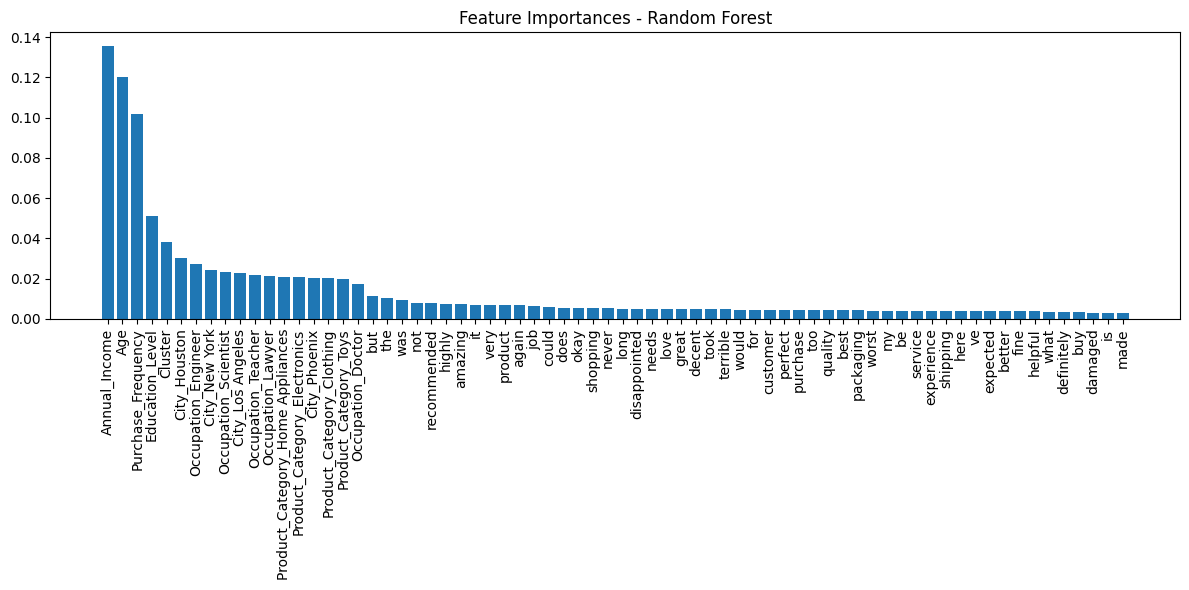

In [10]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter grid for Random Forest.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV for Random Forest.
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest parameters for Random Forest:")
print(grid_search.best_params_)

# Extract the best estimator and visualize feature importances.
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_model.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()



Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


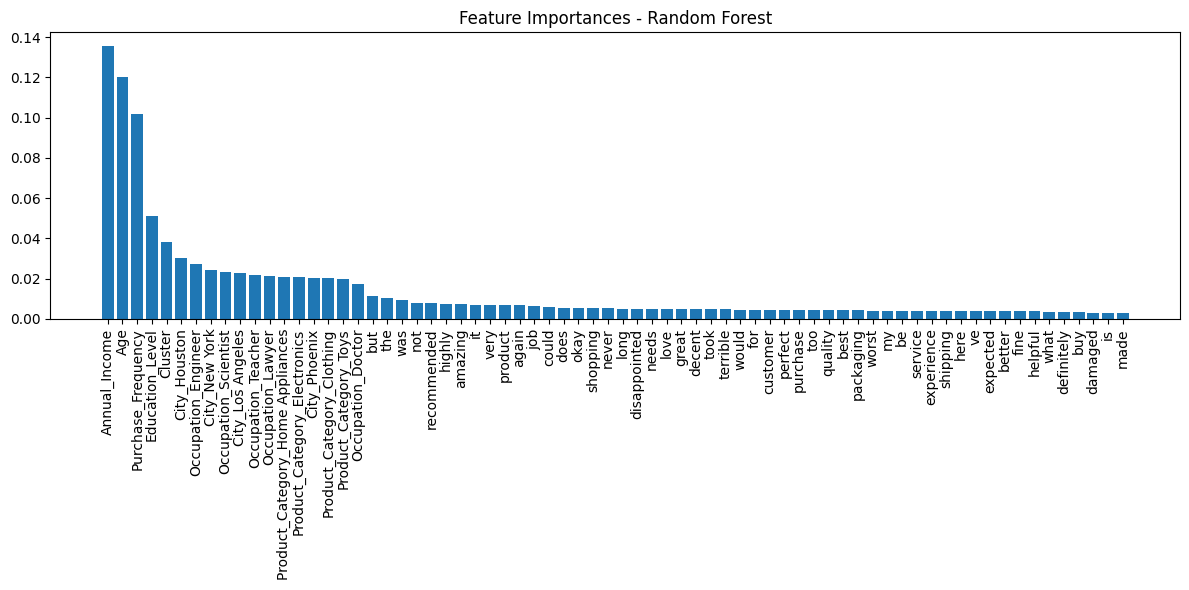

In [11]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV for Random Forest
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("\nBest parameters for Random Forest:")
print(grid_search.best_params_)

# Extract the best estimator and visualize feature importances
best_rf = grid_search.best_estimator_
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_model.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assume X_model and y_model are defined from previous preprocessing steps.
# X_model should be the feature DataFrame (pre-PCA) and y_model the target labels.

# Set up stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the models to evaluate
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),  # probability=True needed for ROC curves later
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Evaluate each model using cross-validation and print the average accuracy with standard deviation
for model_name, model in models.items():
    scores = cross_val_score(model, X_model, y_model, cv=skf, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Decision Tree Cross-Validation Accuracy: 0.3700 ± 0.0192
SVM Cross-Validation Accuracy: 0.3740 ± 0.0260
Random Forest Cross-Validation Accuracy: 0.3370 ± 0.0296
Logistic Regression Cross-Validation Accuracy: 0.3540 ± 0.0302
K-Nearest Neighbors Cross-Validation Accuracy: 0.3610 ± 0.0132
Gradient Boosting Cross-Validation Accuracy: 0.3630 ± 0.0225


Confusion Matrix:
[[106  92 113]
 [119  91 129]
 [ 97 113 140]]


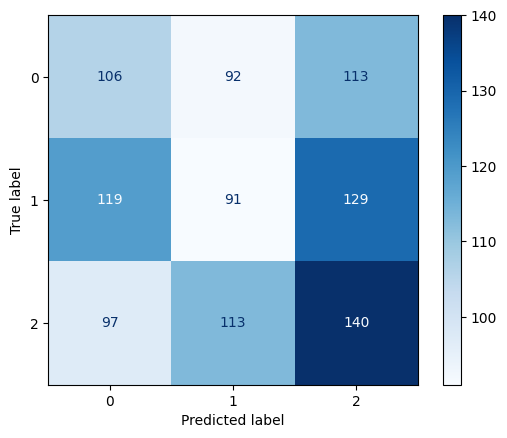

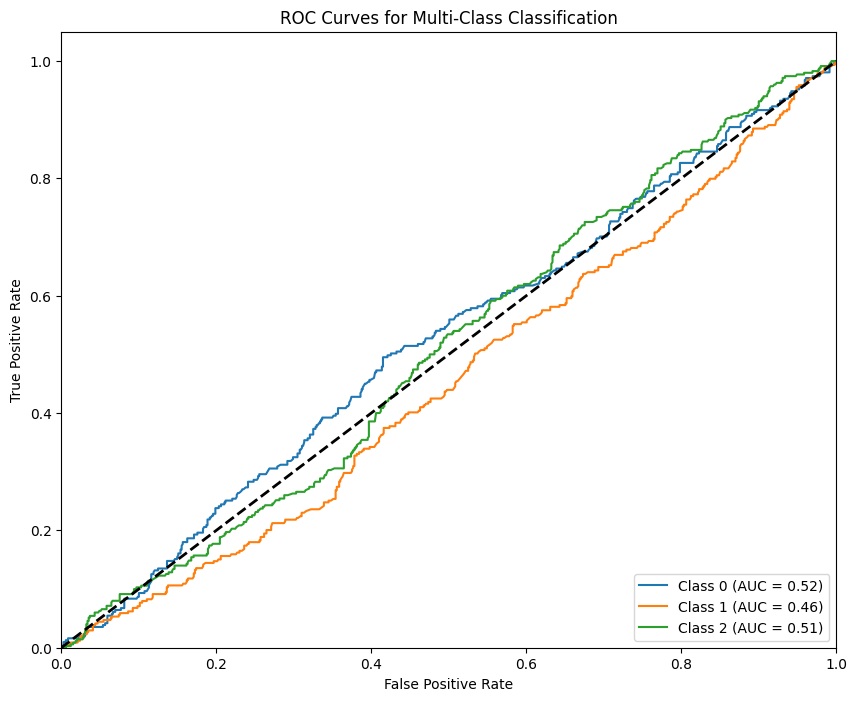

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Choose Random Forest for this demonstration
rf_model = RandomForestClassifier(random_state=42)

# Generate cross-validated predictions for the confusion matrix
y_pred = cross_val_predict(rf_model, X_model, y_model, cv=skf)

# Create and display the confusion matrix
cm = confusion_matrix(y_model, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# -------------------------------
# ROC Curves for Multiclass Classification
# -------------------------------
# Binarize the output labels for a multi-class ROC curve using One-vs-Rest strategy.
# (Assume y_model has classes such as "Low", "Medium", "High"; adjust accordingly.)

classes = np.unique(y_model)
y_bin = label_binarize(y_model, classes=classes)
n_classes = y_bin.shape[1]

# Use OneVsRestClassifier with RandomForest to get probability estimates via cross-validation
ovr = OneVsRestClassifier(RandomForestClassifier(random_state=42))
y_score = cross_val_predict(ovr, X_model, y_model, cv=skf, method='predict_proba')

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()
